<a href="https://colab.research.google.com/github/kshitij1701/IMDB-review-sentiment-analysis/blob/main/IMDB-review-sentiment-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing required libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

### Importing Dataset and pre-processing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Projects/IMDB reviews/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=42)

In [ ]:
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['review'])

In [ ]:
X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['review']), maxlen=max_len)
X_valid = pad_sequences(tokenizer.texts_to_sequences(valid_data['review']), maxlen=max_len)
X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['review']), maxlen=max_len)

### Creating Transformer Model

## 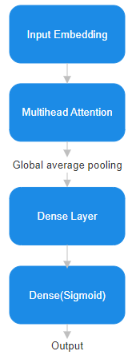

In [ ]:
def transformer_model(input_dim, embed_dim, num_heads, ff_dim, output_dim, max_len):
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim, embed_dim)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(ff_dim, activation='relu')(x)
    outputs = Dense(output_dim, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

In [ ]:
embed_dim = 64
num_heads = 4
ff_dim = 64
output_dim = 1

In [ ]:
model = transformer_model(max_words, embed_dim, num_heads, ff_dim, output_dim, max_len)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

### Model Training

In [ ]:
model.fit(X_train, train_data['sentiment'], epochs=10, batch_size=64, validation_data=(X_valid, valid_data['sentiment']))

Epoch 1/10
563/563 [==============================] - 402s 712ms/step - loss: 0.3555 - accuracy: 0.8306 - val_loss: 0.2819 - val_accuracy: 0.8810
Epoch 2/10
563/563 [==============================] - 397s 705ms/step - loss: 0.2246 - accuracy: 0.9121 - val_loss: 0.2929 - val_accuracy: 0.8758
Epoch 3/10
563/563 [==============================] - 396s 703ms/step - loss: 0.1914 - accuracy: 0.9286 - val_loss: 0.3016 - val_accuracy: 0.8740
Epoch 4/10
563/563 [==============================] - 397s 704ms/step - loss: 0.1634 - accuracy: 0.9375 - val_loss: 0.3199 - val_accuracy: 0.8750
Epoch 5/10
563/563 [==============================] - 479s 851ms/step - loss: 0.1294 - accuracy: 0.9480 - val_loss: 0.4266 - val_accuracy: 0.8625
Epoch 6/10
563/563 [==============================] - 399s 709ms/step - loss: 0.0999 - accuracy: 0.9594 - val_loss: 0.5433 - val_accuracy: 0.8675
Epoch 7/10
563/563 [==============================] - 398s 707ms/step - loss: 0.0792 - accuracy: 0.9682 - val_loss: 0.5984 -

### Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
y_pred = model.predict(X_test)
y_pred_binary = [1 if pred > 0.5 else 0 for pred in y_pred]
test_acc = accuracy_score(test_data['sentiment'], y_pred_binary)
print(f'Test Accuracy: {test_acc*100:.2f}%')

precision = precision_score(test_data['sentiment'], y_pred_binary)
recall = recall_score(test_data['sentiment'], y_pred_binary)
f1 = f1_score(test_data['sentiment'], y_pred_binary)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')

conf_matrix = confusion_matrix(test_data['sentiment'], y_pred_binary)
print('Confusion Matrix:')
print(conf_matrix)


313/313 [==============================] - 39s 125ms/step
Test Accuracy: 86.00%
Precision: 0.8654
Recall: 0.8551
F1-score: 0.8603
Confusion Matrix:
[[4291  670]
 [ 730 4309]]


### Saving The Model

In [ ]:
model.save("/content/drive/MyDrive/Projects/IMDB reviews/sentiment_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model's prediction on random review

In [ ]:
import numpy as np

In [ ]:
new_data = ["Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.I imagine this film would appeal to a stoner who is currently partaking.For something similar but better try Brother from another planet"]
sequences = pad_sequences(tokenizer.texts_to_sequences(new_data), maxlen=max_len)
predictions = model.predict(sequences)

predicted_labels = ["positive" if pred > 0.6 else "negative" for pred in predictions]

print(predicted_labels)

1/1 [==============================] - 0s 24ms/step
['negative']


In [ ]:
new_data = ["Some films just simply should not be remade. This is one of them.In and of itself it is not a bad film. But it fails to capture the flavor and the terror of the 1963 film of the same title. Liam Neeson was excellent as he always is, and most of the cast holds up, with the exception of Owen Wilson, who just did not bring the right feel to the character of Luke. But the major fault with this version is that it strayed too far from the Shirley Jackson story in it's attempts to be grandiose and lost some of the thrill of the earlier film in a trade off for snazzier special effects. Again I will say that in and of itself it is not a bad film. But you will enjoy the friction of terror in the older version much more."]
sequences = pad_sequences(tokenizer.texts_to_sequences(new_data), maxlen=max_len)
predictions = model.predict(sequences)

predicted_labels = ["positive" if pred > 0.6 else "negative" for pred in predictions]

print(predicted_labels)

1/1 [==============================] - 0s 24ms/step
['positive']


In [ ]:
new_data = ["If you want to know the real story of the Wendigo, I suggest you pick up a copy of Algernon Blackwell's original story. This movie was not only bad but had nothing to do with the book.I loved the book when I read it as a kid (In Campfire Chillers by E.M. Freeman)and was so excited to see a movie based on it come out. I was so disappointed when I finally saw it. Another thing is that there were too many PC (Politically Correct) undertones throughout the movie that had no place in the film. When the book was written PC didn't even exist.My suggestion is don't waste your time or money!! If you see it on the video store shelf LEAVE IT THERE."]
sequences = pad_sequences(tokenizer.texts_to_sequences(new_data), maxlen=max_len)
predictions = model.predict(sequences)

predicted_labels = ["positive" if pred > 0.6 else "negative" for pred in predictions]

print(predicted_labels)

1/1 [==============================] - 0s 23ms/step
['negative']


In [ ]:
new_data = ["Tears of Kali is an original yet flawed horror film that delves into the doings of a cult group in India comprised of German psychologists who have learned how to control their wills and their bodies to the point that they can cause others to be healed through radical techniques (that can trigger nightmarish hallucinations and physical pain and torture) to release the pent-up demons inside them.The film is shown as a series of vignettes about the Taylor-Eriksson group--the above-mentioned cult group. The first segment is somewhat slower than the rest but serves fine to set up the premise for the rest of the film. The rest of it plays out like a mindf@ck film with some of the key staples thrown in the mix (full-frontal nudity, some gore) to keep you happy.I say check this out. May not be spectacular, but it's concept is pretty neato and it delivers in the right spots. 8/10."]
sequences = pad_sequences(tokenizer.texts_to_sequences(new_data), maxlen=max_len)
predictions = model.predict(sequences)

predicted_labels = ["positive" if pred > 0.6 else "negative" for pred in predictions]

print(predicted_labels)

1/1 [==============================] - 0s 27ms/step
['positive']
